# __Codename: Plutus IO__

##### __Functional TODOs__:

1. Create generic "adapter" functions to adapt individual configs for certain behaviour
2. Add land
3. Add "tax account"
4. Add concept of a family

In [1]:
# libs
import sys, logging, json
sys.path.append("/home/rado/Projects/wealthManagement/plutus/")

from context.instruments import CurrentAccount, Mortgage
from context.assets import RealEstate
from context.agreements import RentalAgreement, UtilitiesAgreement, EmployeeContract
from context.party import Party, Portfolio
from context.behaviour import transfer
from context.market import extrapolate_index
from core.helpers import configure_run

# delete log
import os
if os.path.exists("plutus.log"): os.remove("plutus.log")

## Setup

In [2]:
# load configmap
with open('_configmap.json') as f: configmap = json.load(f)

# configure run
run_config, market, portfolio, event_config, logger = configure_run(configmap)

In [3]:
# COMPLICATED EVENTS:

# (A) INSTRUMENTS:
# (1) employee contract
# portfolio_config['employee_contracts'][0]['events'] = {'modify': [{'step':2, 'value':0}, {'step':4, 'value': 0}], 'bonus':[{'step':9, 'value':0}]}

# (2) mortgage
# mortgage_flat_events = {'cost': [{'step':4, 'value':10000}, {'step': 5, 'value': 270000}], 'income':{}}

# dump to update versions:
# with open('_config_portfolio.json', 'w') as f: json.dump(portfolio_config, f, indent=4)

# (B) PARTY:
# event_config['transfer'] = transfer(amount=25000, a='rado_current_account', b='rado_saving_account', n_years=run_config['n_years'], frequency=1)
# with open('_config_events.json', 'w') as f: json.dump(event_config, f, indent=4)

In [4]:
# TO BE DELETED
# party-level events
# rado_events = {'sell': [{'step':6, 'id':'rado_mortgage_flat'}]
#              , 'buy': [{'step':8, 'id':'rado_flat3', 'type':'RealEstate', 'current_market_value':3e6, 'property_tax':2000, 'house_community_costs':6000, 'real_estate_index':re_index}]
#              , 'transfer': [{'step':10, 'from':'rado_current_account', 'to':'rado_saving_account','amount':1e6}]}
# rado_events = {'transfer': transfer(amount=25000, a='rado_current_account', b='rado_saving_account', n_years=config['n_years'], frequency=1)}

#### [5] Parties

In [5]:
rado = Party(id='Rado'
             , logger=logger 
             , initial_free_cash=0
             , initial_portfolio=Portfolio(logger, elements = portfolio)
             , monthly_expenditures=50000
             , discount_rate=0.015
             , events=event_config)

## __Simulation__

In [6]:
logger.info('')
logger.info('============================================')
logger.info('============== SIMULATION  =================')
logger.info('============================================')
logger.info('')

In [7]:
rado.live(run_config['n_years']*12+1)

### Plots

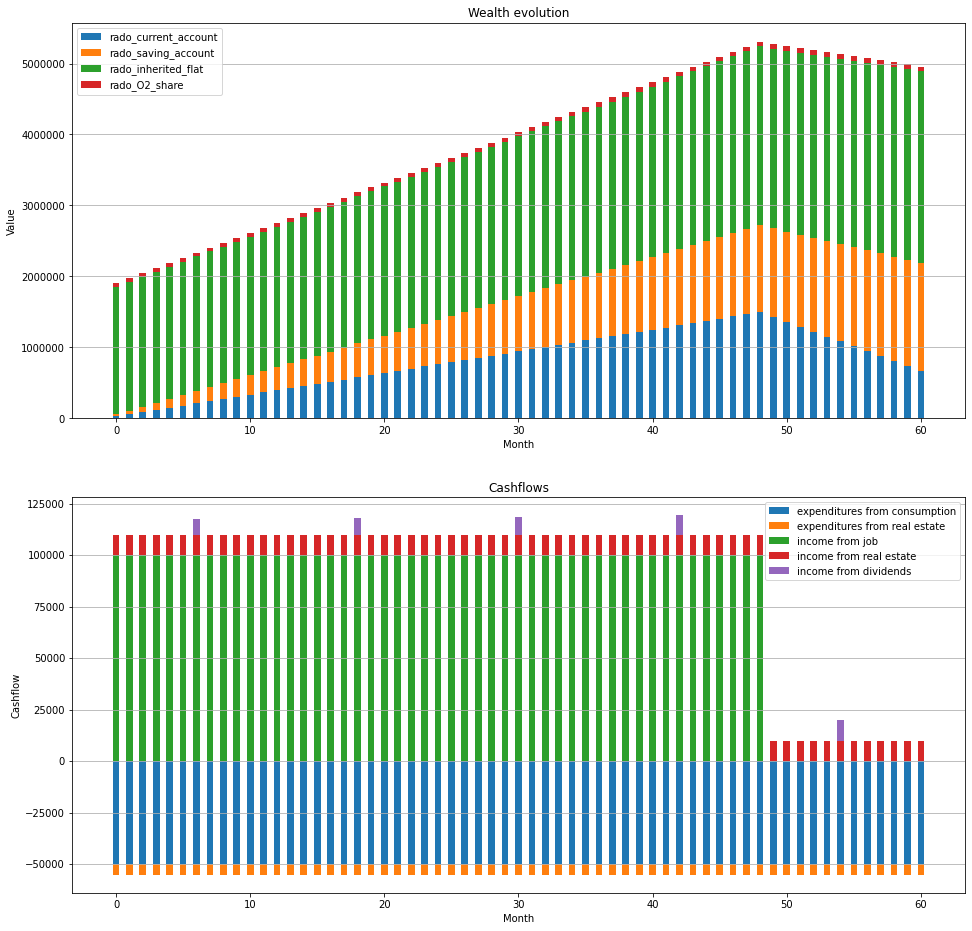

In [8]:
# plots
from core.plots import PartyPlotter

plt = PartyPlotter(rado)
#plt.plot_position_evolution()
plt.plot_wealth_evolution()